In [1]:
#Assignment 5
#Tracking of a moving object which trajectory is disturbed by random acceleration
#Team 12
#Yaroslav Savotin, Elizaveta Pestova, Selamawit
#Skoltech, 2023

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#------------№1,2,3------------
# Initial parameters
N = 200
M = 500
T = 1

#For plots
step = np.arange(N)
step1 = np.arange(N - 3)

sigma = 0.2**2
sigma1 = 20**2


# Initial position and velocity
x0 = np.array([[5], [1]])

# Transition Matrix
Fi = np.array([[1, T], [0, 1]])

# Input Matrix
G = np.array([[(T**2)/2], [T]])

# Observer Matrix
H = np.array([[1], [0]])

In [3]:
def generate_Xt(x0, sigma, Fi, G, N):
    a = np.random.normal(0, np.sqrt(sigma), size=(1, 1, N))
    Xt = np.zeros((2, 1, N))
    Xt[:, :, 0] = x0

    for i in range(1, N):
        Xt[:, :, i] = np.dot(Fi, Xt[:, :, i-1]) + G * a[:, :, i-1]

    return Xt

def generate_Z(sigma1, Xt, H, N):
    nu = np.random.normal(0, np.sqrt(sigma1), size=(1, 1, N))
    Z = np.zeros((1, 1, N))

    for i in range(N):
        Z[:, :, i] = np.dot(H.T, Xt[:, :, i]) + nu[:, :, i]

    return Z

In [4]:
#------------№4------------

# Initial filter estimates
X0 = np.array([[2], [0]])

# Initial filtration error covariance matrices
P0 = np.array([[10000, 0],
               [0, 10000]])

# Process noise matrix Q
Q = G * G.T * sigma

# Measurement noise
R = sigma1

def kalmanFilter(Fi, H, Q, R, X0, P0, Z, N):
    Xp = np.zeros((2, 1, N)) #Prediction of state vector at time i using  (i-1) measurements
    Pp = np.zeros((2, 2, N)) #Prediction error covariance matrix 
    Xf = np.zeros((2, 1, N)) #Improved estimate by incorporating 
    K = np.zeros((2, 1, N)) #Filter gain, weight of residual
    Pf = np.zeros((2, 2, N)) #Filtration error covariance matrix
    Ps = np.zeros((1, 1, N)) 
    
    Pf[:, :, 0] = P0
    Xf[:, :, 0] = X0
    for i in range(1, N):
        #Prediction
        Xp[:, :, i] = np.dot(Fi, Xf[:, :, i-1])
        Pp[:, :, i] = np.dot(np.dot(Fi, Pf[:, :, i-1]), Fi.T) + Q
        
        #Filtration Adjustment
        K[:, :, i] = np.dot(Pp[:, :, i], H)/(np.dot(np.dot(H.T, Pp[:, :, i]), H) + R)
        Xf[:, :, i] = Xp[:, :, i] + np.dot(K[:, :, i], Z[:, :, i] - np.dot(H.T, Xp[:, :, i])) # np.dot(H, Xp[:, i])
        Pf[:, :, i] = np.dot((np.eye(2) - np.dot(K[:, :, i], H.T)), Pp[:, :, i])
        # FOR TASK 6,11 square root of the first diagonal element of Pi,i 
        #that corresponds to standard deviation of estimation error of coordinate xi
        Ps[:, :, i] = np.sqrt(np.abs(np.diag(Pf[:, :, i])[0]))

    return Xf, Pf, K, Ps
 

In [5]:
# Generate true trajectories
Xt = generate_Xt(x0, sigma, Fi, G, N)

# Generate measurement trajectories
Z = generate_Z(sigma1, Xt, H, N)

In [6]:
# Calculate the estimation for true trajectories using Kalman filter
Xf, Pf, K, Ps = kalmanFilter(Fi, H, Q, R, X0, P0, Z, N)

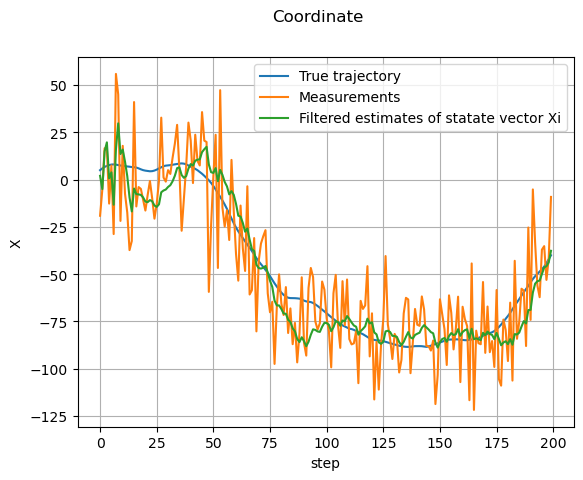

In [7]:
#------------№5------------
y1 = Xt[0][0]
y2 = Z[0][0]
y3 = Xf[0][0]
x = step
plt.plot(x,y1,label = 'True trajectory')
plt.plot(x,y2,label = 'Measurements')
plt.plot(x,y3,label = 'Filtered estimates of statate vector Xi')
plt.xlabel('step')
plt.ylabel('X')
plt.suptitle('Coordinate')
plt.legend()
plt.grid(True)

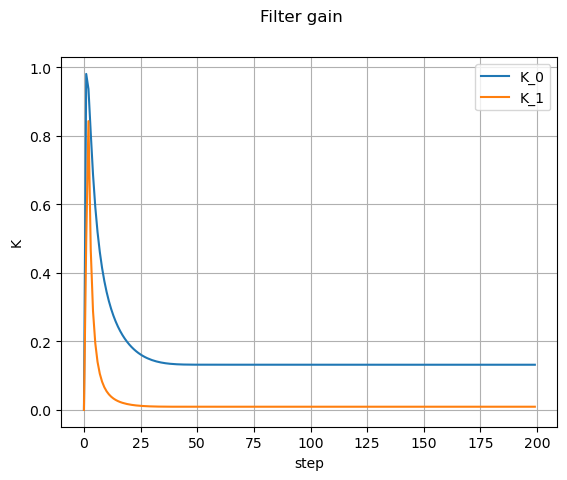

In [8]:
#------------№6------------
#gain K over the whole  filtration interval
y1 = K[0][0]
y2 = K[1][0]
x = step
plt.plot(x,y1,label = 'K_0')
plt.plot(x,y2,label = 'K_1')
plt.xlabel('step')
plt.ylabel('K')
plt.suptitle('Filter gain')
plt.legend()
plt.grid(True)

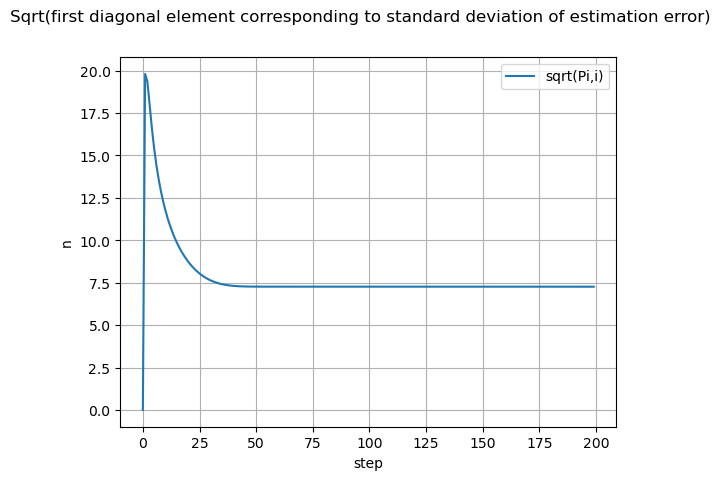

In [9]:
#square root of its first diagonal element corresponding to standard deviation of estimation error of xi
y1 = Ps[0][0]
x = step
plt.plot(x,y1,label = 'sqrt(Pi,i)')
plt.xlabel('step')
plt.ylabel('n')
plt.suptitle('Sqrt(first diagonal element corresponding to standard deviation of estimation error)')
plt.legend()
plt.grid(True)

In [10]:
#Verify whether filter gain � and filtration error covariance matrix become constant very
#quickly. It means that in conditions of a trajectory disturbed by random noise we cannot
#estimate more than established limit of accuracy due to uncertainty.


#ANSWER:Yes, the establishment occurs approximately in 40-50 iterations 

In [11]:
#------------№7------------
def kalman_mSteps(m, Fi, N, Xf):
    Xim = np.zeros((2, 1, N))
    Fim = np.linalg.matrix_power(Fi, m-1)
    
    for i in range(m-1):
        Xim[:, :, i] = Xf[:, :, i]

    for i in range(m-1, N-m):
        Xim[:, :, i+7] = np.dot(Fim, Xf[:, :, i])

    return Xim

In [12]:
# calculating m extraposion of kalman filter
m = 7
Xpm = kalman_mSteps(m,Fi,N,Xf)

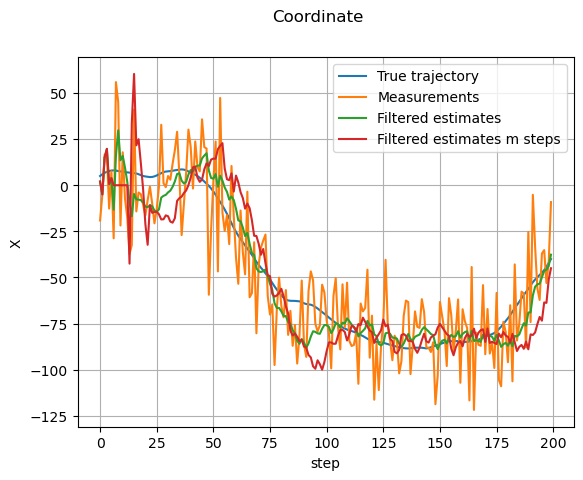

In [13]:
y1 = Xt[0][0]
y2 = Z[0][0]
y3 = Xf[0][0]
y4 = Xpm[0][0]
x = step
plt.plot(x,y1,label = 'True trajectory')
plt.plot(x,y2,label = 'Measurements')
plt.plot(x,y3,label = 'Filtered estimates')
plt.plot(x,y4,label = 'Filtered estimates m steps')
plt.xlabel('step')
plt.ylabel('X')
plt.suptitle('Coordinate')
plt.legend()
plt.grid(True)

In [82]:
#------------№8------------
#mean-squared error
def calculate_MSE(m, N, M, x0, sigma, sigma1, Fi, G, H, Q, R, X0, P0):
    Error_run = np.zeros((2, M, N))
    final_Error = np.zeros((2, 1, N-3))
    Error_run1 = np.zeros((2, M, N))
    final_Error1 = np.zeros((2, 1, N-3))

    for i in range(M):
        Xt = generate_Xt(x0, sigma, Fi, G, N)
        Z = generate_Z(sigma1, Xt, H, N)
        Xf, Pf, K, Ps = kalmanFilter(Fi, H, Q, R, X0, P0, Z, N)
        Xpm = kalman_mSteps(m, Fi, N, Xf)

        for j in range(N):
            Error_run[:, i, j] = ((Xt[:, :, j] - Xf[:, :, j])**2).T[0]
            Error_run1[:, i, j] = ((Xt[:, :, j] - Xpm[:, :, j])**2).T[0]

    for i in range(N-3):
        for k in range(M):
            final_Error[:, :, i] += Error_run[:, k, i+3].T[0]
            final_Error1[:, :, i] += Error_run1[:, k, i+3].T[0]

        final_Error[:, :, i] = np.sqrt(final_Error[:, :, i] / (M - 1))
        final_Error1[:, :, i] = np.sqrt(final_Error1[:, :, i] / (M - 1))

    return final_Error, final_Error1

In [15]:
#Calculating the mean sequare error with P0 = np.array([[1000, 0],[0, 1000]])
MSE1, MSE2 = calculate_MSE(m,N,M,x0,sigma,sigma1,Fi,G,H,Q,R,X0,P0)

In [16]:
#Plot final error and check when it becomes almost constant and estimation accuracy doesn’t
#increase anymore. At this moment filter becomes stationary and in practice this constant
#filter gain can be used in the algorithm instead of calculating filter gain at every ti

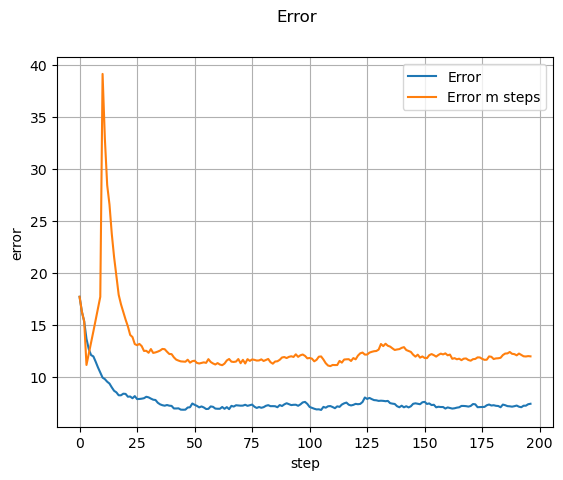

In [17]:
y1 = MSE1[0][0]
y2 = MSE2[0][0]
x = step1
plt.plot(x,y1,label = 'Error')
plt.plot(x,y2,label = 'Error m steps')
plt.xlabel('step')
plt.ylabel('error')
plt.suptitle('Error')
plt.legend()
plt.grid(True)

In [18]:
#------------№9------------
def calculate_SD(Z, Xf, N):
    SD = np.zeros((1, 2, N))

    for j in range(N):
        SD[:, :, j] += ((Z[:, :, j] - Xf[:, :, j])**2).T[0]
        
    for i in range(N):
        SD[:, :, i] = np.sqrt(SD[:, :, i]/(N - 1))

    return SD

In [19]:
SD_error = calculate_SD(Z,Xf,N)
SD_error_mSteps = calculate_SD(Z,Xpm,N)

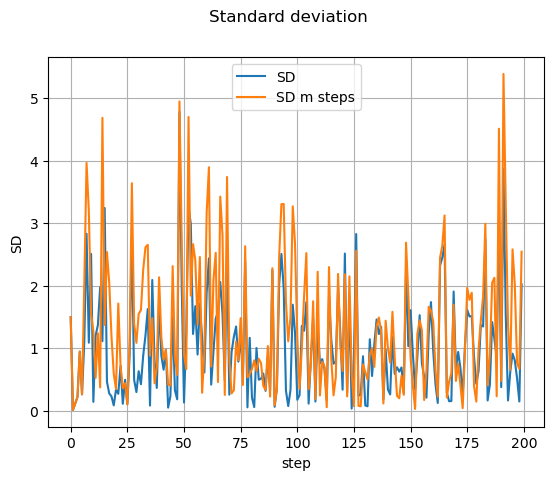

In [20]:
y1 = SD_error[0][0]
y2 = SD_error_mSteps[0][0]
x = step
plt.plot(x,y1,label = 'SD')
plt.plot(x,y2,label = 'SD m steps')
plt.xlabel('step')
plt.ylabel('SD')
plt.suptitle('Standard deviation')
plt.legend()
plt.grid(True)

In [21]:
#------------№10------------
P01 = np.array([[100, 0],
                [0, 100]])

Xf10, Pf10, K10, Ps10 = kalmanFilter(Fi, H, Q, R, X0, P01, Z, N)
#Calculating the mean sequare error  with P01 = np.array([[100, 0],[0, 100]])
MSE3, MSE4 = calculate_MSE(m,N,M,x0,sigma,sigma1,Fi,G,H,Q,R,X0,P01)

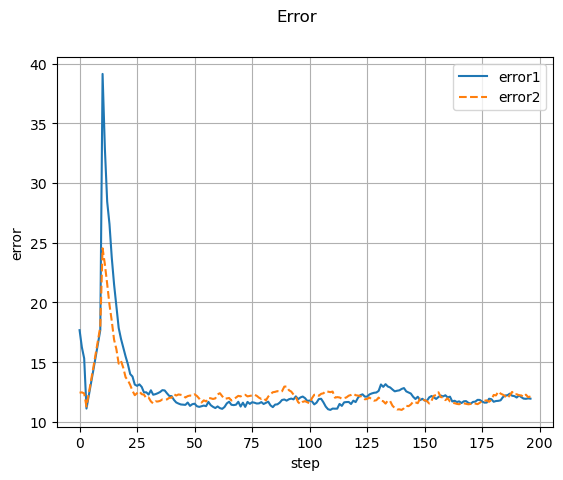

In [22]:
y1 = MSE2[0][0]
y2 = MSE4[0][0]
x = step1
plt.plot(x,y1,label = 'error1')
plt.plot(x,y2,label = 'error2',linestyle = '--')
plt.xlabel('step')
plt.ylabel('error')
plt.suptitle('Error')
plt.legend()
plt.grid(True)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!TASK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Please analyze how the accuracy of initial conditions P0,0 affects the estimation results?
#When the choice of initial conditions doesn’t affect the estimation results?

In [23]:
#------------№11------------
Ps_plot = np.zeros((N-3))
for i in range(N-3):
    Ps_plot[i] = Ps[0][0][i]

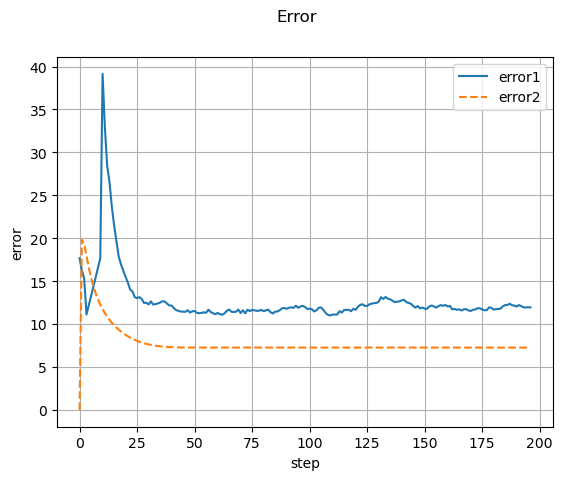

In [24]:
y1 = MSE2[0][0]
y2 = Ps_plot
x = step1
plt.plot(x,y1,label = 'error1')
plt.plot(x,y2,label = 'error2',linestyle = '--')
plt.xlabel('step')
plt.ylabel('error')
plt.suptitle('Error')
plt.legend()
plt.grid(True)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!TASK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Verify if calculation errors of estimation correspond to true estimatimation

In [25]:
#------------№12------------
sigma_0 = 0
Xt_0 = generate_Xt(x0, sigma_0, Fi, G, N)
Z_0 = generate_Z(sigma1, Xt_0, H, N)
Xf_0, Pf_0, K_0, Ps_0 = kalmanFilter(Fi, H, Q, R, X0, P0, Z_0, N)
Xpm_0 = kalman_mSteps(m,Fi,N,Xf_0)


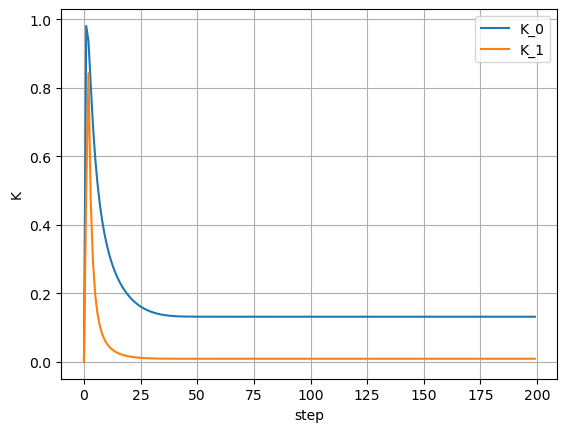

In [26]:
#gain K over the whole  filtration interval
y1 = K[0][0]
y2 = K[1][0]
x = step
plt.plot(x,y1,label = 'K_0')
plt.plot(x,y2,label = 'K_1')
plt.xlabel('step')
plt.ylabel('K')
plt.suptitle('')
plt.legend()

plt.grid(True)

In [27]:
MSE1_0, MSE2_0 = calculate_MSE(m,N,M,x0,sigma_0,sigma1,Fi,G,H,Q,R,X0,P0)
MSE3_0, MSE4_0 = calculate_MSE(m,N,M,x0,sigma_0,sigma1,Fi,G,H,Q,R,X0,P01)

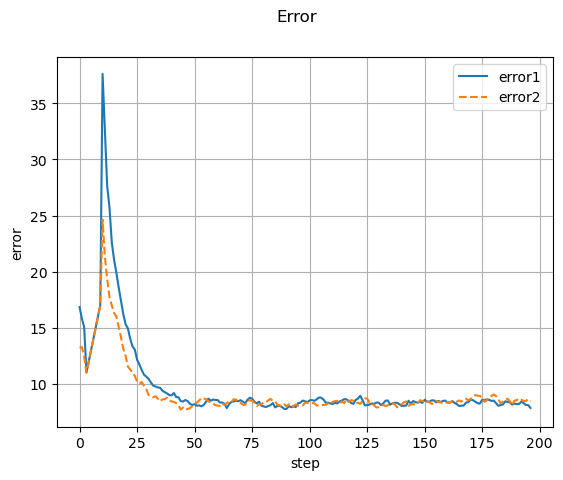

In [28]:
y1 = MSE2_0[0][0]
y2 = MSE4_0[0][0]
x = step1
plt.plot(x,y1,label = 'error1')
plt.plot(x,y2,label = 'error2',linestyle = '--')
plt.xlabel('step')
plt.ylabel('error')
plt.suptitle('Error')
plt.legend()
plt.grid(True)

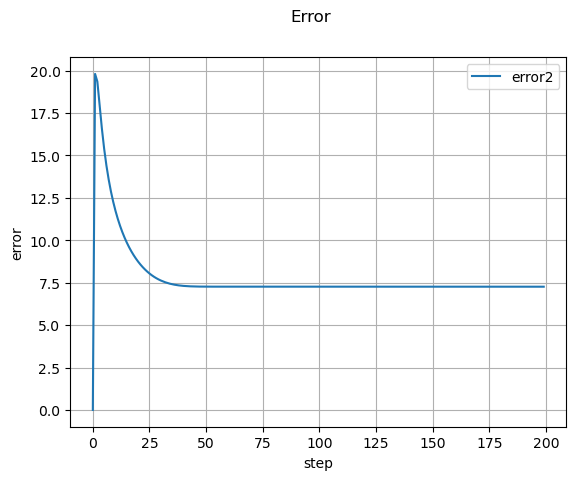

In [29]:
y2 = Ps_0[0][0]
x = step
plt.plot(x,y2,label = 'error2')
plt.xlabel('step')
plt.ylabel('error')
plt.suptitle('Error')
plt.legend()
plt.grid(True)

In [30]:
#------------№13------------
Q = 0
Xt_1 = generate_Xt(x0, sigma, Fi, G, N)
Z_1 = generate_Z(sigma1, Xt_1, H, N)
Xf_1, Pf_1, K_1, Ps_1 = kalmanFilter(Fi, H, Q, R, X0, P0, Z_1, N)
Xpm_1 = kalman_mSteps(m,Fi,N,Xf_1)


In [31]:
MSE1_1, MSE2_1 = calculate_MSE(m,N,M,x0,sigma,sigma1,Fi,G,H,Q,R,X0,P0)
MSE3_1, MSE4_1 = calculate_MSE(m,N,M,x0,sigma,sigma1,Fi,G,H,Q,R,X0,P01)

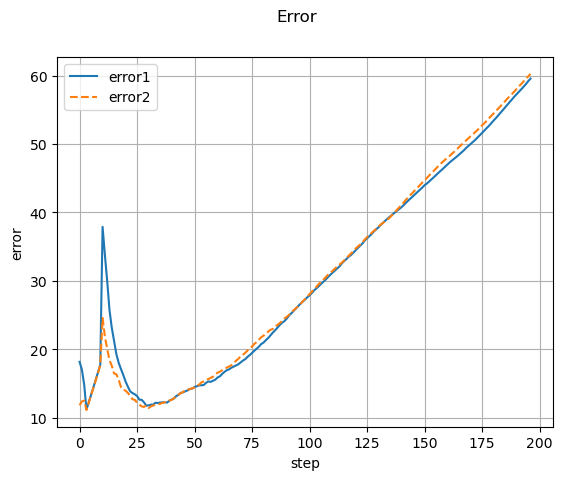

In [32]:
y1 = MSE2_1[0][0]
y2 = MSE4_1[0][0]
x = step1
plt.plot(x,y1,label = 'error1')
plt.plot(x,y2,label = 'error2',linestyle = '--')
plt.xlabel('step')
plt.ylabel('error')
plt.suptitle('Error')
plt.legend()
plt.grid(True)

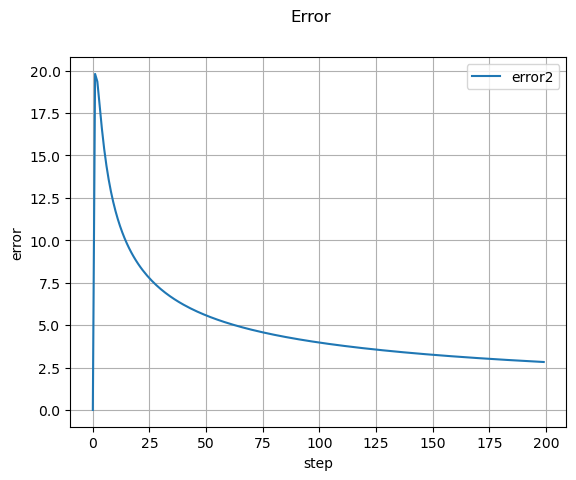

In [33]:
y2 = Ps_1[0][0]
x = step
plt.plot(x,y2,label = 'error2')
plt.xlabel('step')
plt.ylabel('error')
plt.suptitle('Error')
plt.legend()
plt.grid(True)

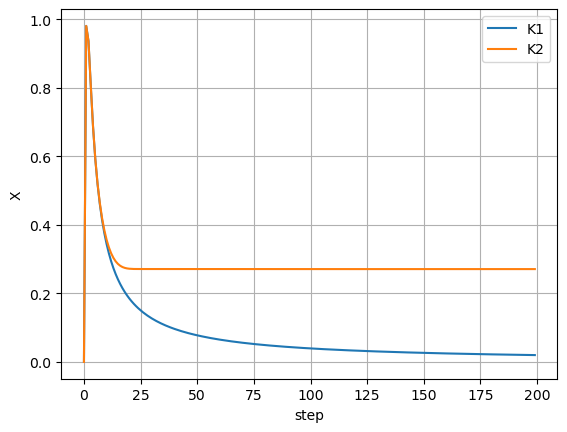

In [34]:
#------------№14------------
sigma_1 = 1
sigma = 0.2**2

Q1 = G * G.T * sigma_1
# Generate true trajectories
X02 = generate_Xt(x0, sigma, Fi, G, N)

# Generate measurement trajectories
Z02 = generate_Z(sigma1, X02, H, N)

# Calculate the estimation for true trajectories using Kalman filter
Xf, Pf, K, Ps = kalmanFilter(Fi, H, Q, R, X0, P0, Z02, N)

X1 = generate_Xt(x0, sigma_1, Fi, G, N)

# Generate measurement trajectories
Z1 = generate_Z(sigma1, X1, H, N)

# Calculate the estimation for true trajectories using Kalman filter
Xf1, Pf1, K1, Ps1 = kalmanFilter(Fi, H, Q1, R, X0, P0, Z1, N)


y1 = K[0][0]
y2 = K1[0][0]
y3 = X1[0][0]
x = step
plt.plot(x,y1,label = 'K1')
plt.plot(x,y2,label = 'K2')
#plt.plot(x,y3,label = 'filtered estimates (sigma = 1)')
plt.xlabel('step')
plt.ylabel('X')
#plt.ylim(0,0.1)
plt.suptitle('')
plt.legend()
plt.grid(True)

In [35]:
Accuracy_error1 = 0 #sigma_1 = 1
Accuracy_error2 = 0 #sigma = 0.2**2

for i in range(N):
    Accuracy_error1 += (X02[0,0,i] - Xf[0,0,i])**2  
    Accuracy_error2 += (X1[0,0,i] - Xf1[0,0,i])**2
    
Accuracy_error1 = np.sqrt(Accuracy_error1/N)
Accuracy_error2 = np.sqrt(Accuracy_error2/N)

print(Accuracy_error1, Accuracy_error2)


10.21811879182357 10.204169026082896


In [84]:
#------------№15------------
sigma = 0.2**2

# Initial filtration error covariance matrices
P0 = np.array([[10000, 0],
               [0, 10000]])

# Process noise matrix Q
Q = G * G.T * sigma

# Measurement noise
R = sigma1


X1 = np.array([[100], [5]]) # Initial filter estimates


# Generate true trajectories
X_15 = generate_Xt(x0, sigma, Fi, G, N)

# Generate measurement trajectories
Z = generate_Z(sigma1, X_15, H, N)

# Calculate the estimation for true trajectories using Kalman filter
Xf, Pf, K, Ps = kalmanFilter(Fi, H, Q, R, X1, P0, Z, N)

MSE15_1, MSE15_2 = calculate_MSE(m,N,M,x0,sigma,sigma1,Fi,G,H,Q,R,X1,P0)

In [76]:
def kalmanFilter15(Fi, H, Q, R, X0, P0, Z, N,K_underestimated):
    Xp = np.zeros((2, 1, N)) #Prediction of state vector at time i using  (i-1) measurements
    Pp = np.zeros((2, 2, N)) #Prediction error covariance matrix 
    Xf = np.zeros((2, 1, N)) #Improved estimate by incorporating 
    K = np.zeros((2, 1, N)) #Filter gain, weight of residual
    Pf = np.zeros((2, 2, N)) #Filtration error covariance matrix
    Ps = np.zeros((1, 1, N)) 
    
    Pf[:, :, 0] = P0
    Xf[:, :, 0] = X0
    for i in range(1, N):
        Xp[:, :, i] = np.dot(Fi, Xf[:, :, i-1])
        Pp[:, :, i] = np.dot(np.dot(Fi, Pf[:, :, i-1]), Fi.T) + Q
        Xf[:, :, i] = Xp[:, :, i] + np.dot(K_underestimated, Z[:, :, i] - np.dot(H.T, Xp[:, :, i])) # np.dot(H, Xp[:, i])
        Pf[:, :, i] = np.dot((np.eye(2) - K_underestimated)*H.T, Pp[:, :, i])
        # FOR TASK 6,11 square root of the first diagonal element of Pi,i 
        #that corresponds to standard deviation of estimation error of coordinate xi
        Ps[:, :, i] = np.sqrt(np.abs(np.diag(Pf[:, :, i])[0]))

    return Xf, Pf, K, Ps
 

In [85]:
K_underestimated = K[0][0][199]/5

Xf15, Pf15, K15, Ps15 = kalmanFilter15(Fi, H, Q, R, X0, P0, Z, N,K_underestimated)

In [86]:
def calculate_MSE15(m, N, M, x0, sigma, sigma1, Fi, G, H, Q, R, X0, P0,K_underestimated):
    Error_run = np.zeros((2, M, N))
    final_Error = np.zeros((2, 1, N-3))
    Error_run1 = np.zeros((2, M, N))
    final_Error1 = np.zeros((2, 1, N-3))

    for i in range(M):
        Xt = generate_Xt(x0, sigma, Fi, G, N)
        Z = generate_Z(sigma1, Xt, H, N)
        Xf, Pf, K, Ps = kalmanFilter15(Fi, H, Q, R, X0, P0, Z, N,K_underestimated)
        Xpm = kalman_mSteps(m, Fi, N, Xf)

        for j in range(N):
            Error_run[:, i, j] = ((Xt[:, :, j] - Xf[:, :, j])**2).T[0]
            Error_run1[:, i, j] = ((Xt[:, :, j] - Xpm[:, :, j])**2).T[0]

    for i in range(N-3):
        for k in range(M):
            final_Error[:, :, i] += Error_run[:, k, i+3].T[0]
            final_Error1[:, :, i] += Error_run1[:, k, i+3].T[0]

        final_Error[:, :, i] = np.sqrt(final_Error[:, :, i] / (M - 1))
        final_Error1[:, :, i] = np.sqrt(final_Error1[:, :, i] / (M - 1))

    return final_Error, final_Error1

In [87]:
MSE15_3, MSE15_4 = calculate_MSE15(m,N,M,x0,sigma,sigma1,Fi,G,H,Q,R,X1,P0,K_underestimated)

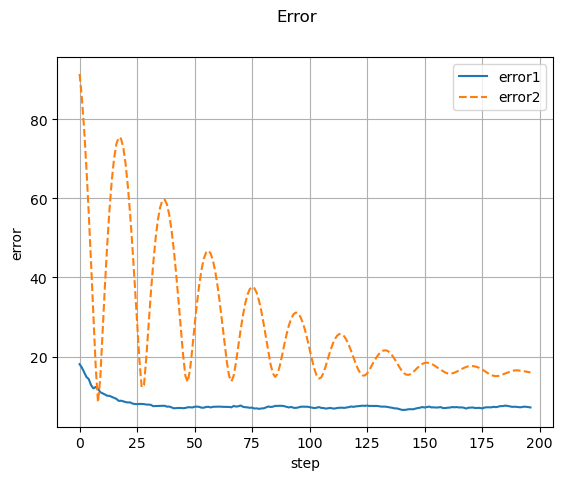

In [88]:
y1 = MSE15_1[0][0]
y2 = MSE15_3[0][0]
x = step1
plt.plot(x,y1,label = 'error1')
plt.plot(x,y2,label = 'error2',linestyle = '--')
plt.xlabel('step')
plt.ylabel('error')
plt.suptitle('Error')
plt.legend()
plt.grid(True)

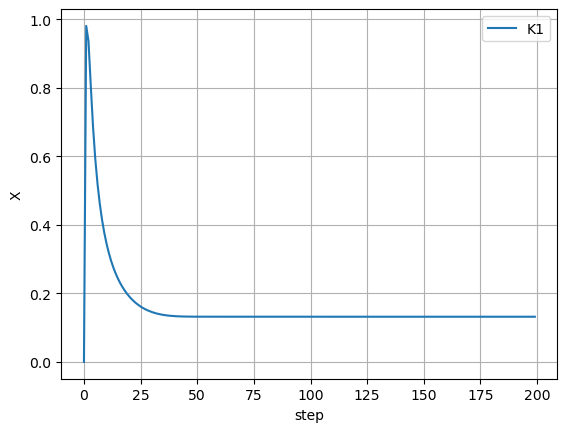

In [81]:

y1 = K[0][0]
y2 = K1[0][0]
y3 = X1[0][0]
x = step
plt.plot(x,y1,label = 'K1')
#plt.plot(x,y2,label = 'K2')
#plt.plot(x,y3,label = 'filtered estimates (sigma = 1)')
plt.xlabel('step')
plt.ylabel('X')
#plt.ylim(0,0.1)
plt.suptitle('')
plt.legend()
plt.grid(True)